# FBS with Inconsistent FRFs
This notebook shows an example of how FRFs that have inconsistent modal properties reference-to-reference, such as errors in the natural frequencies (like how nonlinearities commonly effect the FRFs) can lead to errors in the FBS coupled FRFs. This example uses the [beam model](generate_beam_example_system). As a reminder, the individual beam components and coupled beam system are shown below, where beam one is the blue beam and beam two is the red beam. 

![Beam1](./Images/beam1.svg)

![Beam2](./Images/beam2.svg)

Beams one and two are overlapped by 10 cm and are coupled to one another at three (evenly spaced) points at each end of the beam, as shown as the green dots in the image below.

![CoupledBeams](./Images/CoupledBeams.svg)

## General Process for this Example
This example computes the FRFs from the modal properties of the system where the natural frequencies of the system have been perturbed to simulate slight changes in the FRFs due to nonlinearities. These perturbations will be described in more detail below. 

## Importing Information for the Example
This section imports the necessary packages and data for the beam example systems. The data for the uncoupled systems are imported as SDynPy `System` objects and are called `beam1_system` and `beam2_system`. The truth FRFs are still imported as a SDynPy `TransferFunctionArray` and are called `beam1_truth_frfs`, `beam2_truth_frfs`, and `coupled_system_frfs`. The CMIFs for the truth FRFs are also computed here because they will be used for a summary comparison between the perturbed and truth FRFs. The CMIFs are called `beam1_cmif`, `beam2_cmif`, and `coupled_cmif`, based on the system they are representative of.

In [1]:
import sdynpy as sdpy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
beam1_system = sdpy.System.load(r'./example_systems/beam1_system.npz')
beam2_system = sdpy.System.load(r'./example_systems/beam2_system.npz')

beam1_truth_frfs = sdpy.TransferFunctionArray.load(r'./example_frfs/beam1_frfs.npz')
beam2_truth_frfs = sdpy.TransferFunctionArray.load(r'./example_frfs/beam2_frfs.npz')
coupled_system_frfs = sdpy.TransferFunctionArray.load(r'./example_frfs/coupled_beam_system_frfs.npz')

In [3]:
beam1_cmif = beam1_truth_frfs.compute_cmif()
beam2_cmif = beam2_truth_frfs.compute_cmif()
coupled_cmif = coupled_system_frfs.compute_cmif()

## Generate the FRFs with Inconsistent Modal Properties
This section generates the FRFs with inconsistent references, which will be used in the FBS coupling in this example. The FRFs are made inconsistent by randomly perturbing natural frequencies of the beam, where the perturbation is different for each reference. This will be done for three levels of perturbation to demonstrate the sensitivity of the FBS problem to the inconsistent FRFs. 

In [4]:
beam1_modes = beam1_system.eigensolution()
# Only the first nine frequencies will be compared to the perturbed data
beam1_frequencies = beam1_modes.frequency[:9, np.newaxis] 

beam2_modes = beam2_system.eigensolution()
# Only the first nine frequencies will be compared to the perturbed data
beam2_frequencies = beam2_modes.frequency[:9, np.newaxis] 

In [5]:
beam1_coupling_coordinate = sdpy.coordinate_array(node=[1161, 1181, 1201], direction=[3,5], 
                                                  force_broadcast=True)
beam1_evaluation_coordinate = sdpy.coordinate_array(node=[1001, 1051, 1101, 1151], direction=3)
beam1_frf_coordinate = np.concatenate((beam1_coupling_coordinate, 
                                       beam1_evaluation_coordinate))

In [6]:
beam2_coupling_coordinate = sdpy.coordinate_array(node=[2001, 2021, 2041], direction=[3,5], force_broadcast=True) 
beam2_evaluation_coordinate = sdpy.coordinate_array(node=[2051, 2101, 2151, 2201], direction=3)
beam2_frf_coordinate = np.concatenate((beam2_coupling_coordinate, 
                                       beam2_evaluation_coordinate))

The so-called "inconsistent frfs" are generated with the function that is shown below. The natural frequencies are perturbed by multiplying the natural frequencies by a random numbers that are close to one, where each natural frequency has a different perturbation. The random number generator is specified with a seed and standard deviation. 

The random seed is used to get repeatable results over multiple function calls. The standard deviation is proportional to the average percentage variation in the natural frequency compared to the truth and is adjusted to achieve smaller or larger perturbations. Lastly, the random seed is incremented for every reference, which is how the perturbations are varied for each reference.

```{note}
This function returns the perturbed natural frequencies so they can be compared to the truth natural frequencies to characterize the magnitude of the perturbations.  
```

```{note}
The perturbation method that is being used here is for example purposes only and may not be what is seen in actual test data.
```

In [7]:
def perturbed_frequency_frfs(mode_shapes, frf_coordinate, rng_seed, rng_std_dev):
    """
    Computes FRFs from a set of shapes where the natural frequencies have been 
    perturbed be a random amount via a random number generator. The perturbation
    is different for each reference in the FRF matrix. 

    Parameters
    ----------
    mode_shapes : ShapeArray
        The mode shapes to compute the FRFs from.
    frf_coordinate : CoordinateArray
        The response and reference coordinates for the FRFs (this function 
        computes a square FRF matrix). 
    rng_seed : int
        The starting seed for the random number generator that perturbs the 
        natural frequencies. The seed is incremented by 20 for every reference.
    rng_seed_dev : float
        The standard deviation for the random number generator that perturbs the 
        natural frequencies. This value is proportional to the average frequency 
        error in the perturbation.

    Returns
    -------
    perturbed_frfs : TransferFunctionArray
        The FRFs that are computed from the mode shapes with perturbed natural
        frequencies. 
    perturbed_frequencies : ndarray
        The perturbed natural frequencies. It is organized [# of modes, # of references].
    """
    perturbed_frfs = []
    perturbed_frequencies = []
    for coord in frf_coordinate:
        loop_rng = np.random.default_rng(seed=rng_seed)

        perturbed_modes = mode_shapes.copy()
        perturbed_modes.frequency *= loop_rng.normal(loc=1, scale=rng_std_dev, 
                                                     size=mode_shapes.shape[0])
        perturbed_frequencies.append(perturbed_modes.frequency)

        loop_frfs = perturbed_modes.compute_frf(np.arange(100001), frf_coordinate, coord, 
                                                displacement_derivative=2)
        perturbed_frfs.append(loop_frfs.extract_elements_by_abscissa(0, 5000))

        rng_seed += 20

    return np.column_stack(perturbed_frfs), np.column_stack(perturbed_frequencies)

### Low Level Perturbation

In [8]:
beam1_inconsistent_frfs_low, beam1_perturbed_frequencies_low = perturbed_frequency_frfs(beam1_modes, beam1_frf_coordinate, 
                                                                                        rng_seed=2020, rng_std_dev=0.001)
beam1_inconsistent_cmif_low = beam1_inconsistent_frfs_low.compute_cmif()

In [9]:
beam2_inconsistent_frfs_low, beam2_perturbed_frequencies_low = perturbed_frequency_frfs(beam2_modes, beam2_frf_coordinate, 
                                                                                        rng_seed=2025, rng_std_dev=0.001)
beam2_inconsistent_cmif_low = beam2_inconsistent_frfs_low.compute_cmif()

#### Comparing the Low Level Perturbed Properties to Truth
The influence of the natural frequency perturbation is demonstrated with two quantities of interest:

1. Natural Frequency Error - The average natural frequency error (for all the references) will be shown for the first nine modes to show the significance of the perturbation. Only the first nine modes are compared because they are the modes in the frequency range of interest.
2. The First CMIF - The first CMIF for the truth and inconsistent FRFs will be compared to summarize the differences between the truth and inconsistent FRFs. 

The natural frequency error shows that the perturbations have a minor impact on the modal properties of the beams. Similarly, the perturbed and truth CMIFs appear to have the same general shape, but the amplitude of the perturbed CMIFs is lower than the truth CMIFs. The reason for the amplitude change in the CMIF are unknown, but could potentially be due to the FRFs being smeared over a wider frequency band (because of the natural frequency perturbations).

In [10]:
beam1_rms_freq_error_low = np.mean(np.abs(100*(beam1_perturbed_frequencies_low[:9,:]-
                                               beam1_frequencies)/beam1_frequencies), axis=1)

beam2_rms_freq_error_low = np.mean(np.abs(100*(beam2_perturbed_frequencies_low[:9,:]-
                                               beam2_frequencies)/beam2_frequencies), axis=1)

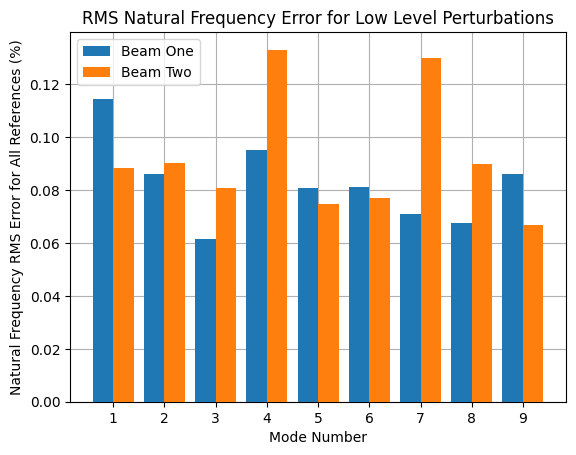

In [11]:
plt.figure()
plt.bar(np.arange(9)+0.8, beam1_rms_freq_error_low, width=0.4, label='Beam One', zorder=3)
plt.bar(np.arange(9)+1.2, beam2_rms_freq_error_low, width=0.4, label='Beam Two', zorder=3)
plt.xticks(np.arange(9)+1)
plt.xlabel('Mode Number')
plt.ylabel('Natural Frequency RMS Error for All References (%)')
plt.title('RMS Natural Frequency Error for Low Level Perturbations')
plt.legend()
plt.grid(zorder=0)

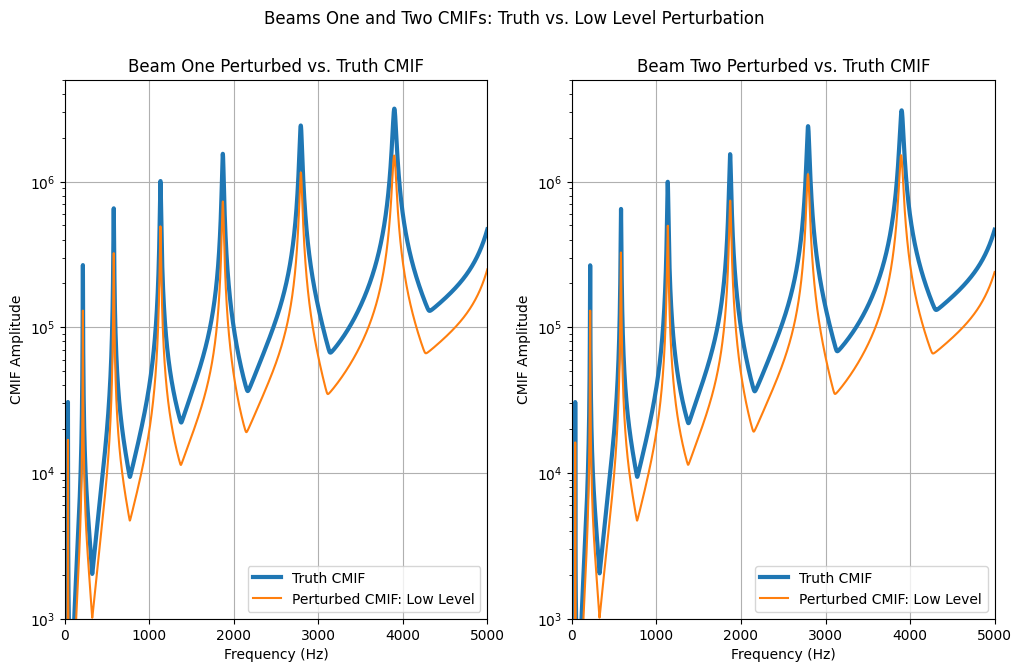

In [12]:
fig, ax = plt.subplots(1,2, figsize=(12,7))

ax[0].semilogy(beam1_cmif[0].abscissa, beam1_cmif[0].ordinate, label='Truth CMIF', 
               linewidth=3)
ax[0].semilogy(beam1_inconsistent_cmif_low[0].abscissa, beam1_inconsistent_cmif_low[0].ordinate, 
               label='Perturbed CMIF: Low Level', linewidth=1.5)
ax[0].grid()
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('CMIF Amplitude')
ax[0].set_title('Beam One Perturbed vs. Truth CMIF')
ax[0].legend()
ax[0].set_xlim(left=0, right=5000)
ax[0].set_ylim(bottom=10e2, top=5e6)

ax[1].semilogy(beam2_cmif[0].abscissa, beam2_cmif[0].ordinate, label='Truth CMIF', 
               linewidth=3)
ax[1].semilogy(beam2_inconsistent_cmif_low[0].abscissa, beam2_inconsistent_cmif_low[0].ordinate, 
               label='Perturbed CMIF: Low Level', linewidth=1.5)
ax[1].grid()
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('CMIF Amplitude')
ax[1].set_title('Beam Two Perturbed vs. Truth CMIF')
ax[1].legend()
ax[1].set_xlim(left=0, right=5000)
ax[1].set_ylim(bottom=10e2, top=5e6)

fig.suptitle('Beams One and Two CMIFs: Truth vs. Low Level Perturbation');

### Medium Level Perturbation
Note that the same random seed is used for the low and medium level perturbations, meaning that the distribution of frequency errors will be the exactly the same as the low level, but with a higher amplitude. 

In [13]:
beam1_inconsistent_frfs_med, beam1_perturbed_frequencies_med = perturbed_frequency_frfs(beam1_modes, beam1_frf_coordinate, 
                                                                                        rng_seed=2020, rng_std_dev=0.004)
beam1_inconsistent_cmif_med = beam1_inconsistent_frfs_med.compute_cmif()

In [14]:
beam2_inconsistent_frfs_med, beam2_perturbed_frequencies_med = perturbed_frequency_frfs(beam2_modes, beam2_frf_coordinate, 
                                                                                        rng_seed=2025, rng_std_dev=0.004)
beam2_inconsistent_cmif_med = beam2_inconsistent_frfs_med.compute_cmif()

#### Comparing the Medium Level Perturbed Properties to Truth
As expected, the medium level perturbations show similar types of errors to the low level perturbations, but with a higher amplitude.

In [15]:
beam1_rms_freq_error_med = np.mean(np.abs(100*(beam1_perturbed_frequencies_med[:9,:]-
                                               beam1_frequencies)/beam1_frequencies), axis=1)

beam2_rms_freq_error_med = np.mean(np.abs(100*(beam2_perturbed_frequencies_med[:9,:]-
                                               beam2_frequencies)/beam2_frequencies), axis=1)

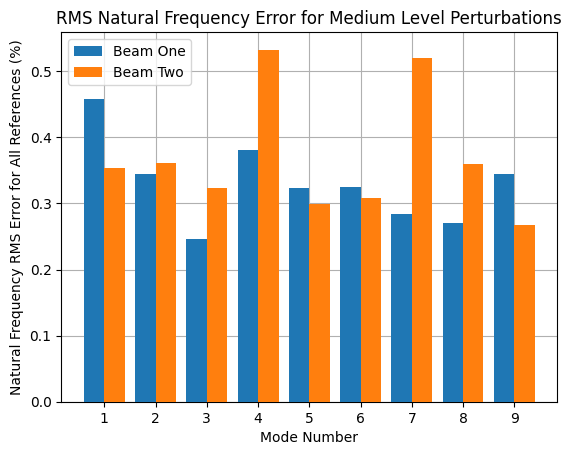

In [16]:
plt.figure()
plt.bar(np.arange(9)+0.8, beam1_rms_freq_error_med, width=0.4, label='Beam One', zorder=3)
plt.bar(np.arange(9)+1.2, beam2_rms_freq_error_med, width=0.4, label='Beam Two', zorder=3)
plt.xticks(np.arange(9)+1)
plt.xlabel('Mode Number')
plt.ylabel('Natural Frequency RMS Error for All References (%)')
plt.title('RMS Natural Frequency Error for Medium Level Perturbations')
plt.legend()
plt.grid(zorder=0)

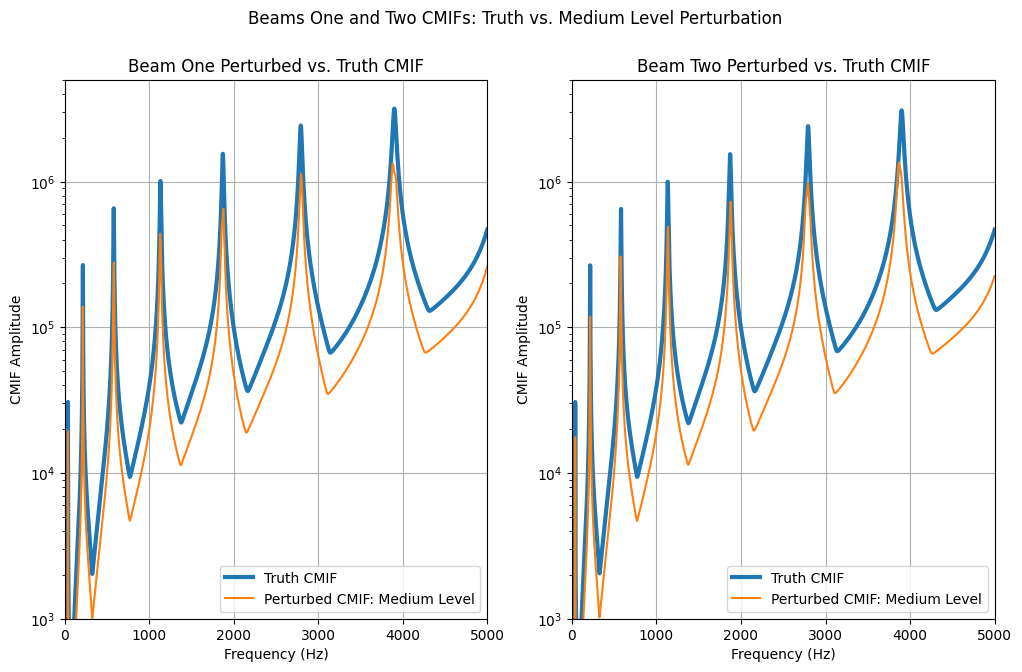

In [17]:
fig, ax = plt.subplots(1,2, figsize=(12,7))

ax[0].semilogy(beam1_cmif[0].abscissa, beam1_cmif[0].ordinate, label='Truth CMIF', 
               linewidth=3)
ax[0].semilogy(beam1_inconsistent_cmif_med[0].abscissa, beam1_inconsistent_cmif_med[0].ordinate, 
               label='Perturbed CMIF: Medium Level', linewidth=1.5)
ax[0].grid()
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('CMIF Amplitude')
ax[0].set_title('Beam One Perturbed vs. Truth CMIF')
ax[0].legend()
ax[0].set_xlim(left=0, right=5000)
ax[0].set_ylim(bottom=10e2, top=5e6)

ax[1].semilogy(beam2_cmif[0].abscissa, beam2_cmif[0].ordinate, label='Truth CMIF', 
               linewidth=3)
ax[1].semilogy(beam2_inconsistent_cmif_med[0].abscissa, beam2_inconsistent_cmif_med[0].ordinate, 
               label='Perturbed CMIF: Medium Level', linewidth=1.5)
ax[1].grid()
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('CMIF Amplitude')
ax[1].set_title('Beam Two Perturbed vs. Truth CMIF')
ax[1].legend()
ax[1].set_xlim(left=0, right=5000)
ax[1].set_ylim(bottom=10e2, top=5e6)

fig.suptitle('Beams One and Two CMIFs: Truth vs. Medium Level Perturbation');

### High Level Perturbation
Note that the same random seed is used for the low, medium, and high level perturbations, meaning that the distribution of frequency errors will be the exactly the same as the low and medium levels, but with a higher amplitude. 

In [18]:
beam1_inconsistent_frfs_high, beam1_perturbed_frequencies_high = perturbed_frequency_frfs(beam1_modes, beam1_frf_coordinate, 
                                                                                          rng_seed=2020, rng_std_dev=0.008)
beam1_inconsistent_cmif_high = beam1_inconsistent_frfs_high.compute_cmif()

In [19]:
beam2_inconsistent_frfs_high, beam2_perturbed_frequencies_high = perturbed_frequency_frfs(beam2_modes, beam2_frf_coordinate, 
                                                                                          rng_seed=2025, rng_std_dev=0.008)
beam2_inconsistent_cmif_high = beam2_inconsistent_frfs_high.compute_cmif()

#### Comparing the High Level Perturbed Properties to Truth
As expected, the high level perturbations show similar types of errors to the low and medium level perturbations, but with a higher amplitude. The biggest difference is in the CMIFs, where several peaks show evidence of splitting.

In [20]:
beam1_rms_freq_error_high = np.mean(np.abs(100*(beam1_perturbed_frequencies_high[:9,:]-
                                                beam1_frequencies)/beam1_frequencies), axis=1)

beam2_rms_freq_error_high = np.mean(np.abs(100*(beam2_perturbed_frequencies_high[:9,:]-
                                                beam2_frequencies)/beam2_frequencies), axis=1)

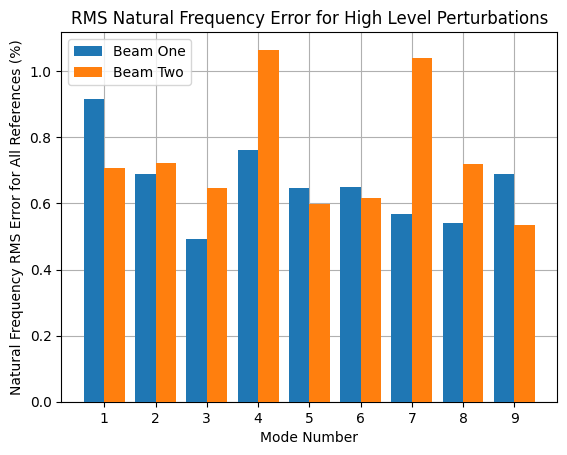

In [21]:
plt.figure()
plt.bar(np.arange(9)+0.8, beam1_rms_freq_error_high, width=0.4, label='Beam One', zorder=3)
plt.bar(np.arange(9)+1.2, beam2_rms_freq_error_high, width=0.4, label='Beam Two', zorder=3)
plt.xticks(np.arange(9)+1)
plt.xlabel('Mode Number')
plt.ylabel('Natural Frequency RMS Error for All References (%)')
plt.title('RMS Natural Frequency Error for High Level Perturbations')
plt.legend()
plt.grid(zorder=0)

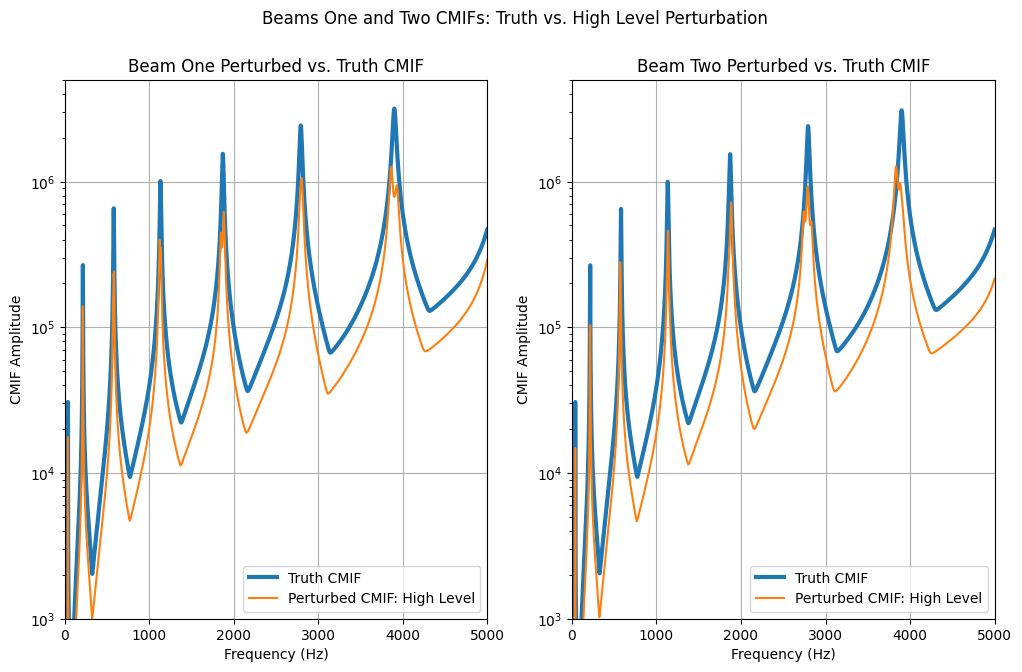

In [22]:
fig, ax = plt.subplots(1,2, figsize=(12,7))

ax[0].semilogy(beam1_cmif[0].abscissa, beam1_cmif[0].ordinate, label='Truth CMIF', 
               linewidth=3)
ax[0].semilogy(beam1_inconsistent_cmif_high[0].abscissa, beam1_inconsistent_cmif_high[0].ordinate, 
               label='Perturbed CMIF: High Level', linewidth=1.5)
ax[0].grid()
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('CMIF Amplitude')
ax[0].set_title('Beam One Perturbed vs. Truth CMIF')
ax[0].legend()
ax[0].set_xlim(left=0, right=5000)
ax[0].set_ylim(bottom=10e2, top=5e6)

ax[1].semilogy(beam2_cmif[0].abscissa, beam2_cmif[0].ordinate, label='Truth CMIF', 
               linewidth=3)
ax[1].semilogy(beam2_inconsistent_cmif_high[0].abscissa, beam2_inconsistent_cmif_high[0].ordinate, 
               label='Perturbed CMIF: High Level', linewidth=1.5)
ax[1].grid()
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('CMIF Amplitude')
ax[1].set_title('Beam Two Perturbed vs. Truth CMIF')
ax[1].legend()
ax[1].set_xlim(left=0, right=5000)
ax[1].set_ylim(bottom=10e2, top=5e6)

fig.suptitle('Beams One and Two CMIFs: Truth vs. High Level Perturbation');

## FBS Coupling
This section performs the FBS coupling with the inconsistent FRFs that have different levels of perturbations. The errors in the FBS coupling are demonstrated by comparing the CMIFs for the truth and FBS coupled FRF (at the "evaluation coordinate"), as shown below. Two main errors are seen in these plots:

- The FBS coupling leads to some split peaks at resonant frequencies
- There are spurious peaks in the FBS coupled FRFs

```{note}
As expected, the errors in the FBS coupling become more significant as the perturbations become more significant.
```

In [ ]:
coupling_coordinate_pairs = np.column_stack((beam1_coupling_coordinate, beam2_coupling_coordinate))

bd_low_inconsistent_frfs = sdpy.TransferFunctionArray.block_diagonal_frf((beam1_inconsistent_frfs_low, 
                                                                          beam2_inconsistent_frfs_low))
fbs_coupled_low_inconsistent_frfs = bd_low_inconsistent_frfs.substructure_by_coordinate(coupling_coordinate_pairs)

bd_med_inconsistent_frfs = sdpy.TransferFunctionArray.block_diagonal_frf((beam1_inconsistent_frfs_med, 
                                                                          beam2_inconsistent_frfs_med))
fbs_coupled_med_inconsistent_frfs = bd_med_inconsistent_frfs.substructure_by_coordinate(coupling_coordinate_pairs)

bd_high_inconsistent_frfs = sdpy.TransferFunctionArray.block_diagonal_frf((beam1_inconsistent_frfs_high, 
                                                                           beam2_inconsistent_frfs_high))
fbs_coupled_high_inconsistent_frfs = bd_high_inconsistent_frfs.substructure_by_coordinate(coupling_coordinate_pairs)

In [ ]:
comparison_coordinate = np.concatenate((beam1_evaluation_coordinate, 
                                        beam2_evaluation_coordinate))
comparison_coordinate = sdpy.coordinate.outer_product(comparison_coordinate, 
                                                      comparison_coordinate)

coupled_cmif = coupled_system_frfs[comparison_coordinate].compute_cmif()
fbs_low_cmif = fbs_coupled_low_inconsistent_frfs[comparison_coordinate].compute_cmif()
fbs_med_cmif = fbs_coupled_med_inconsistent_frfs[comparison_coordinate].compute_cmif()
fbs_high_cmif = fbs_coupled_high_inconsistent_frfs[comparison_coordinate].compute_cmif()

Text(0, 0.5, 'CMIF Amplitude')

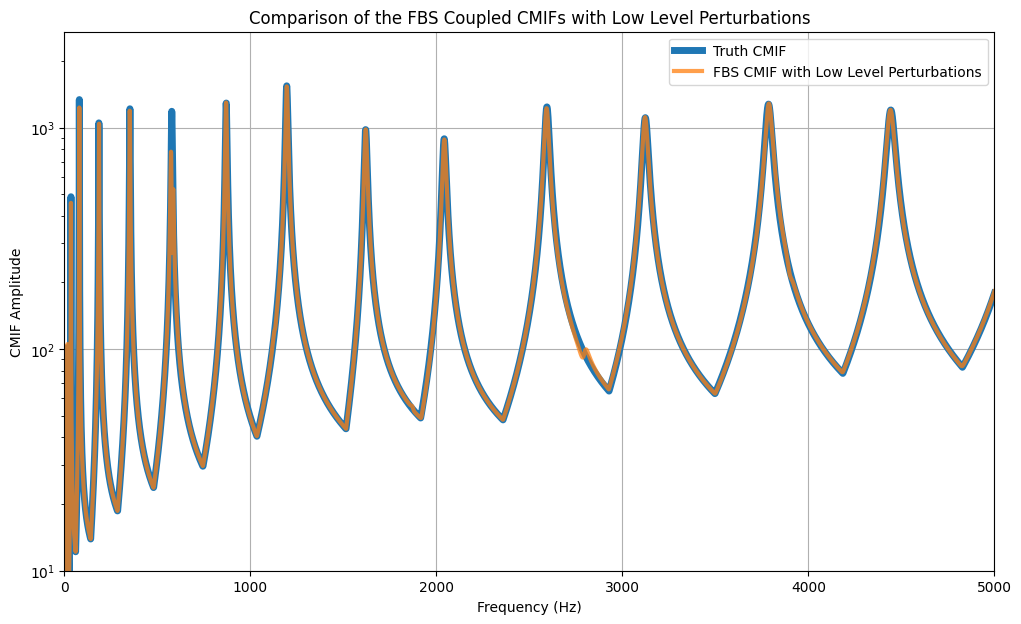

In [25]:
plt.figure(figsize=(12,7))
plt.semilogy(coupled_cmif[0].abscissa, coupled_cmif[0].ordinate, linewidth=5, 
             label='Truth CMIF')
plt.semilogy(fbs_low_cmif[0].abscissa, fbs_low_cmif[0].ordinate, linewidth=3, 
             alpha=0.75, label='FBS CMIF with Low Level Perturbations')
plt.xlim(left=0, right=5000)
plt.ylim(bottom=1e1)
plt.grid()
plt.legend()
plt.title('Comparison of the FBS Coupled CMIFs with Low Level Perturbations')
plt.xlabel('Frequency (Hz)')
plt.ylabel('CMIF Amplitude')

Text(0, 0.5, 'CMIF Amplitude')

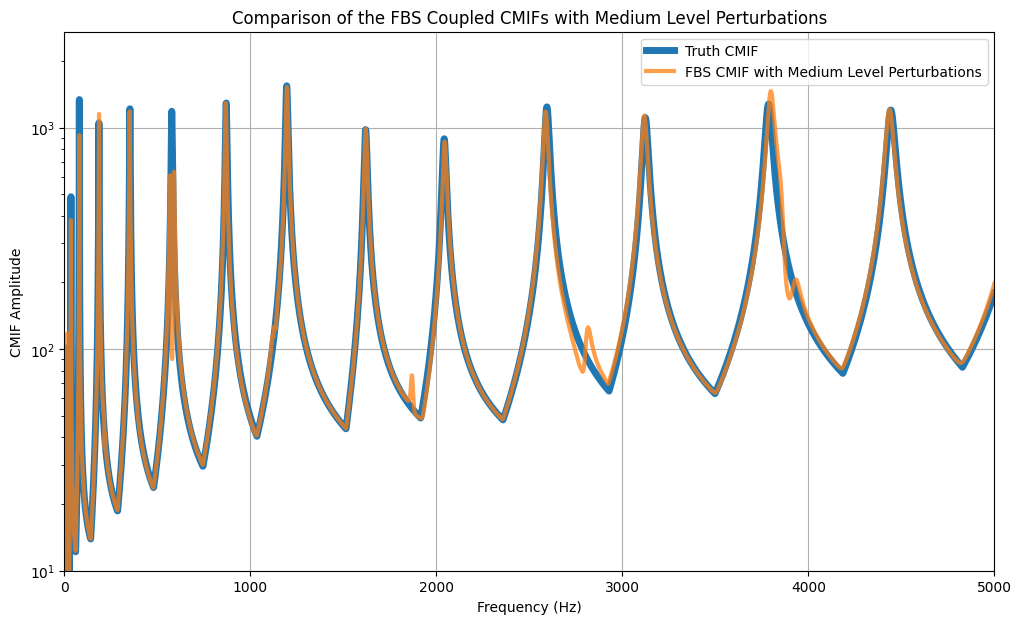

In [26]:
plt.figure(figsize=(12,7))
plt.semilogy(coupled_cmif[0].abscissa, coupled_cmif[0].ordinate, linewidth=5, label='Truth CMIF')
plt.semilogy(fbs_med_cmif[0].abscissa, fbs_med_cmif[0].ordinate, linewidth=3, 
             alpha=0.75, label='FBS CMIF with Medium Level Perturbations')
plt.xlim(left=0, right=5000)
plt.ylim(bottom=1e1)
plt.grid()
plt.legend()
plt.title('Comparison of the FBS Coupled CMIFs with Medium Level Perturbations')
plt.xlabel('Frequency (Hz)')
plt.ylabel('CMIF Amplitude')

Text(0, 0.5, 'CMIF Amplitude')

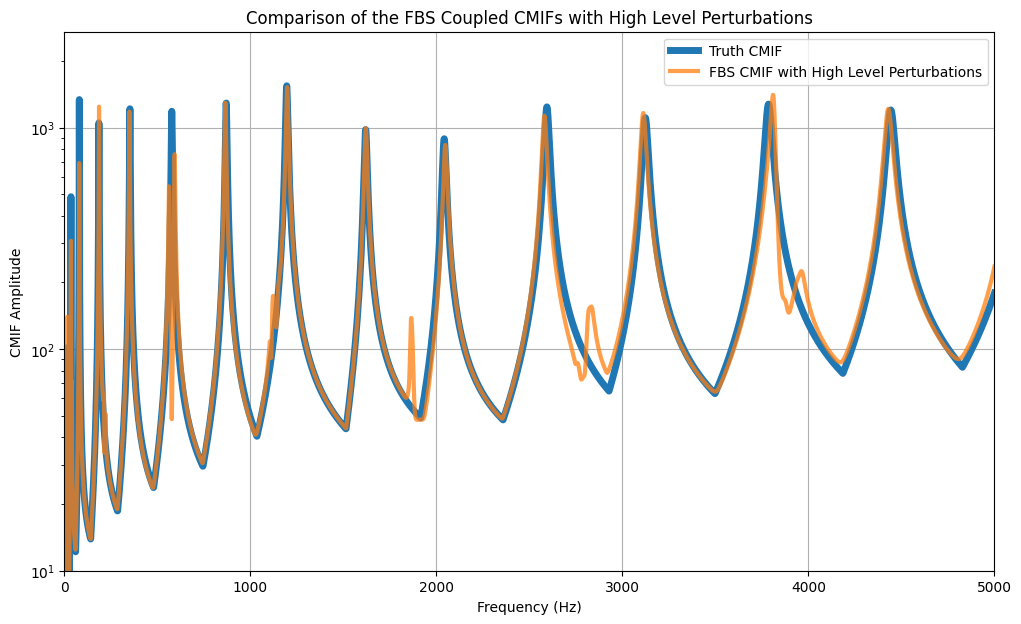

In [27]:
plt.figure(figsize=(12,7))
plt.semilogy(coupled_cmif[0].abscissa, coupled_cmif[0].ordinate, linewidth=5, label='Truth CMIF')
plt.semilogy(fbs_high_cmif[0].abscissa, fbs_high_cmif[0].ordinate, linewidth=3, 
             alpha=0.75, label='FBS CMIF with High Level Perturbations')
plt.xlim(left=0, right=5000)
plt.ylim(bottom=1e1)
plt.grid()
plt.legend()
plt.title('Comparison of the FBS Coupled CMIFs with High Level Perturbations')
plt.xlabel('Frequency (Hz)')
plt.ylabel('CMIF Amplitude')

## Conclusions
This notebook demonstrated how inconsistent modal properties for the different FRFs from different references, like what can be seen with nonlinear systems, can lead to significant errors in the FBS coupled FRFs. It also showed how these errors become more pronounced as the inconsistencies increase in amplitude.

```{warning}
Although the spurious peaks are obvious in this example, it may be difficult to detect them in complicated systems with high modal density.
``` 